In [ ]:
#| tags: [parameters]
# Default values (overridden by -P at render time)
SYMBOL = "AAPL"
START  = "2018-01-01"
END    = ""
ROLL   =  20

In [ ]:
#| echo: true
#| message: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path

# SYMBOL = params.get("symbol", "AAPL")
# START  = params.get("start_date", "2018-01-01")
# END    = params.get("end_date", "")
# ROLL   = int(params.get("rolling", 20))
if not END:
  END = pd.Timestamp.today().strftime("%Y-%m-%d")

In [ ]:
#| echo: true
try:
  data = yf.download(SYMBOL, start=START, end=END, auto_adjust=True, progress=False)
except Exception as e:
  # Synthetic fallback
  idx = pd.bdate_range(START, END)
  rng = np.random.default_rng(42)
  ret = rng.normal(0, 0.01, len(idx))
  price = 100 * np.exp(np.cumsum(ret))
  vol = rng.integers(1e5, 5e6, len(idx))
  data = pd.DataFrame({"Close": price, "Volume": vol}, index=idx)

df = (data.rename(columns=str.lower)[["close","volume"]]
        .dropna()
        .assign(log_return=lambda d: np.log(d["close"]).diff()))
df["roll_mean"] = df["log_return"].rolling(ROLL, min_periods=ROLL//2).mean()
df["roll_vol"]  = df["log_return"].rolling(ROLL, min_periods=ROLL//2).std()
df = df.dropna()

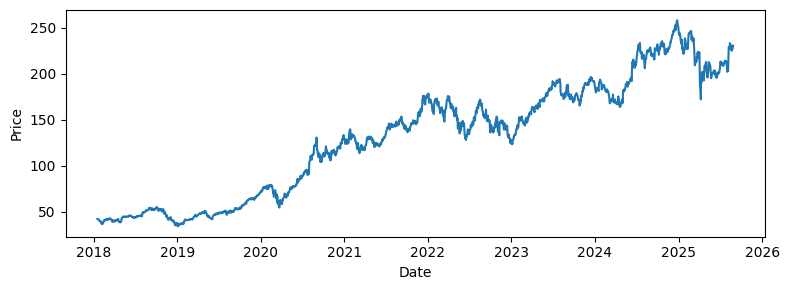

In [ ]:
#| label: fig-price
#| fig-cap: "{SYMBOL} — Adjusted Close"
#| fig-alt: "Line chart showing adjusted close price of the selected stock over time."
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["close"])
ax.set_xlabel("Date"); ax.set_ylabel("Price")
fig.tight_layout()

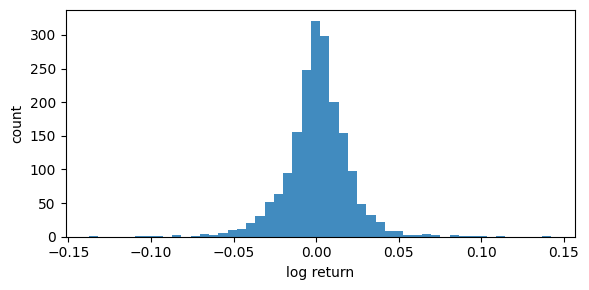

In [ ]:
#| label: fig-hist
#| fig-cap: "{SYMBOL} — Daily log return histogram"
#| fig-alt: "Histogram of daily log returns."
#| echo: false
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df["log_return"], bins=50, alpha=0.85)
ax.set_xlabel("log return"); ax.set_ylabel("count")
fig.tight_layout()

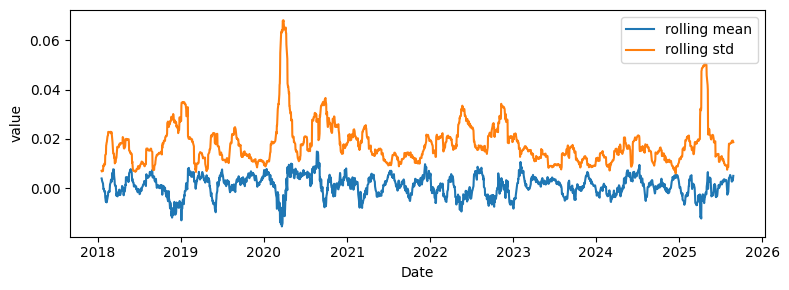

In [ ]:
#| label: fig-rolling
#| fig-cap: "{SYMBOL} — Rolling mean and volatility"
#| fig-alt: "Two line plots of rolling mean and rolling standard deviation of returns."
#| echo: false
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["roll_mean"], label="rolling mean")
ax.plot(df.index, df["roll_vol"],  label="rolling std")
ax.set_xlabel("Date"); ax.set_ylabel("value")
ax.legend()
fig.tight_layout()

In [ ]:
#| label: tbl-summary
#| tbl-cap: "Summary statistics for {SYMBOL}."
#| echo: false
summary = pd.DataFrame({
    "n_days": [len(df)],
    "start": [df.index.min().date()],
    "end":   [df.index.max().date()],
    "mean_daily_ret": [df["log_return"].mean()],
    "std_daily_ret":  [df["log_return"].std()],
    "ann_vol_approx": [df["log_return"].std()*np.sqrt(252)]
})
summary

,n_days,start,end,mean_daily_ret,std_daily_ret,ann_vol_approx
0,1914,2018-01-17,2025-08-27,0.000898,0.019663,0.312136


In [ ]:
#| label: tbl-dict
#| tbl-cap: "Data dictionary for computed columns."
#| echo: false
desc = {
  "close": "Adjusted closing price.",
  "volume": "Trading volume.",
  "log_return": "log(Close_t) − log(Close_{t−1}).",
  "roll_mean": f"Rolling mean of log returns (window={ROLL}).",
  "roll_vol": f"Rolling std of log returns (window={ROLL})."
}
# dd = pd.DataFrame({
#   "column": list(desc.keys()),
#   "dtype": [str(df[c].dtype) for c in desc.keys()],
#   "description": list(desc.values()) })
# dd

#Build a mapping: first-level name -> combined dtype(s)
dtype_by_price = (
    df.dtypes                          # Series indexed by (Price, Ticker)
      .groupby(level=0)                # group by first level "Price"
      .apply(lambda s: " / ".join(sorted({str(dt) for dt in s})))
)

dd = pd.DataFrame({
    "column": list(desc.keys()),
    "dtype": [dtype_by_price.get(c, "MISSING") for c in desc.keys()],
    "description": list(desc.values())
})
dd


,column,dtype,description
0,close,float64,Adjusted closing price.
1,volume,int64,Trading volume.
2,log_return,float64,log(Close_t) − log(Close_{t−1}).
3,roll_mean,float64,Rolling mean of log returns (window=20).
4,roll_vol,float64,Rolling std of log returns (window=20).


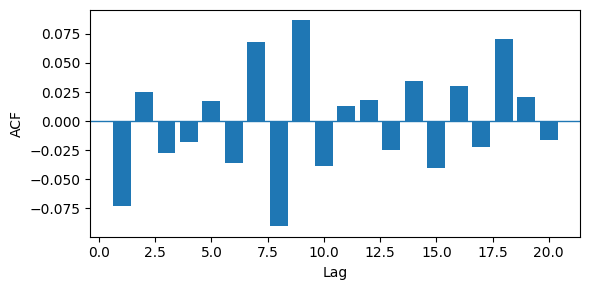

In [50]:
#| label: fig-acf
#| fig-cap: "{SYMBOL} — Autocorrelation of daily log returns (lags 1–20)"
#| fig-alt: "Bar chart of autocorrelation coefficients for lags 1 to 20."
#| echo: false
import numpy as np
import matplotlib.pyplot as plt

# simple ACF (biased) up to max_lag
x = df["log_return"].fillna(0.0).values
x = x - x.mean()
max_lag = 20
acf = []
for k in range(1, max_lag+1):
    num = np.sum(x[:-k] * x[k:])
    den = np.sum(x * x)
    acf.append(num/den if den != 0 else 0.0)

fig, ax = plt.subplots(figsize=(6,3))
ax.bar(range(1, max_lag+1), acf)
ax.axhline(0, linewidth=1)
ax.set_xlabel("Lag"); ax.set_ylabel("ACF")
fig.tight_layout()

In [51]:
#| label: tbl-monthly
#| tbl-cap: "{SYMBOL} — Monthly mean of daily log returns"
#| echo: false
monthly = (df["log_return"]
           .groupby([df.index.year.rename("year"), df.index.month.rename("month")])
           .mean()
           .reset_index()
           .pivot(index="year", columns="month", values="log_return")
           .round(4))
monthly

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,-0.0046,0.0035,-0.0028,-0.0007,0.0058,-0.0005,0.0013,0.0079,-0.0004,-0.0013,-0.0095,-0.0065
2019,0.0026,0.0023,0.0044,0.0026,-0.0060,0.0061,0.0033,-0.0008,0.0035,0.0046,0.0037,0.0045
2020,0.0025,-0.0064,-0.0033,0.0069,0.0041,0.0062,0.0069,0.0093,-0.0052,-0.0028,0.0046,0.0049
2021,-0.0003,-0.0044,0.0003,0.0035,-0.0026,0.0043,0.0030,0.0019,-0.0034,0.0027,0.0048,0.0033
2022,-0.0008,-0.0029,0.0024,-0.0051,-0.0027,-0.0040,0.0086,-0.0014,-0.0061,0.0050,-0.0016,-0.0062
2023,0.0052,0.0012,0.0049,0.0015,0.0020,0.0043,0.0006,-0.0019,-0.0046,-0.0001,0.0051,0.0007
2024,-0.0021,-0.0009,-0.0026,-0.0003,0.0056,0.0048,0.0024,0.0014,0.0009,-0.0013,0.0025,0.0026
2025,-0.0030,0.0013,-0.0040,-0.0021,-0.0026,0.0011,0.0005,0.0056,NaN,NaN,NaN,NaN
